In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.preprocessing.image import ImageDataGenerator


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print(os.listdir("../input"))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['aptos2019-blindness-detection', 'densenet121weights']


In [2]:
import pandas as pd
import numpy as np
from prettytable import PrettyTable
import pickle
import os

# Image Libs.
from PIL import Image
import cv2

import matplotlib.pyplot as plt

from keras.layers import GlobalAveragePooling2D, Flatten, Dense, GaussianDropout, BatchNormalization, Dropout, Conv2D, MaxPooling2D
from keras.models import Model
from keras import regularizers, optimizers
from tensorflow.keras.optimizers import Adam
from keras.applications.densenet import DenseNet121

from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)


In [3]:
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
train_df['diagnosis'] = train_df['diagnosis'].astype('str')
train_df['id_code'] = train_df['id_code'].astype(str)+'.png'


In [4]:
image_size = 224
epochs = 25
batch_size = 16
NUM_CLASSES=5

base="../input/aptos2019-blindness-detection/train_images/"

In [5]:
# image height and image width ----> GLOBAL

# def displayImage(display_name, image):
#     cv2.namedWindow(display_name,cv2.WINDOW_AUTOSIZE)
#     cv2.imshow(display_name, image)


def findContourEye(thresh_image):
    cnts = cv2.findContours(thresh_image.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
    

    cnts = max(cnts[0], key=cv2.contourArea)
    return cnts

def findContourEyeExtreme(cnts):
    # Locating extreme points on all 4 sides
    leftmost = tuple(cnts[cnts[:,:,0].argmin()][0])
    rightmost = tuple(cnts[cnts[:,:,0].argmax()][0])
    topmost = tuple(cnts[cnts[:,:,1].argmin()][0])
    bottommost = tuple(cnts[cnts[:,:,1].argmax()][0])
    # Locating the top left and bottom right corner
    x1 = leftmost[0]
    y1 = topmost[1]
    x2 = rightmost[0]
    y2 = bottommost[1]
    return x1,y1,x2,y2 

def findRadiusAndCentreOfContourEye(cnts):
    M = cv2.moments(cnts)
    if( M["m00"]==0):
        cX, cY = 0, 0
    else:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    if(cX < cY):
        r = cX
    else:
        r = cY
    return cX,cY,r

def drawCentreOnContourEye(image,cnts,cX,cY):
    cv2.drawContours(image, [cnts], -1, (0, 255, 0), 2)
    cv2.circle(image, (cX, cY), 7, (255, 255, 255), -1)
    cv2.putText(image, "center", (cX - 20, cY - 20),
    cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    return image
    
def Radius_Reduction(img,cX,cY,r):
    h,w,c=img.shape
    Frame=np.zeros((h,w,c),dtype=np.uint8)
    cv2.circle(Frame,(int(cX),int(cY)),int(r), (255,255,255), -1)
    Frame1=cv2.cvtColor(Frame, cv2.COLOR_BGR2GRAY)
    img1 =cv2.bitwise_and(img,img,mask=Frame1)
    return img1

def imageResize(image, ht, wd):
    # resized_image = imutils.resize(image, height = ht, width = wd)
    resized_image = cv2.resize(image,(wd,ht))
    return resized_image

def crop_black(image):
    org = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(blurred, 10, 255, cv2.THRESH_BINARY)[1]
    # displayImage('thresh',thresh)
    cnts = findContourEye(thresh)
    x1,y1,x2,y2 = findContourEyeExtreme(cnts)
    ext_x = int((x2 - x1)*4//100)
    ext_y = int((y2 - y1)*5//100)

    crop = org[y1+ext_y:y2-ext_y, x1+ext_x:x2-ext_x]
    crop = imageResize(crop, image_size, image_size)
    return crop

def imageAugmentation(image):
    x_flip = cv2.flip( image, 0 )
    y_flip = cv2.flip( image, 1 )
    xy_flip = cv2.flip(x_flip,1)
    return x_flip, y_flip, xy_flip

def imageHistEqualization(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final

def subtract_median_bg_image(im):
    k = np.max(im.shape)//20*2+1
    bg = cv2.medianBlur(im, k)
    sub_med = cv2.addWeighted (im, 1, bg, -1, 255)
    return sub_med

def colorEnhancement(image1,image2):
    image_final = cv2.bitwise_and(image1,image2)
    return image_final

def new_preprocess_image(image):
    image = imageResize(image, image_size, image_size)
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    image_crop = crop_black(image)
    image_clahe = imageHistEqualization(image_crop)
    sub_med = subtract_median_bg_image(image_clahe)
    image_final = colorEnhancement(sub_med, image_clahe)
    return image_final.astype(np.float32)

def preprocess_image(image_path, desired_size=380):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    return im

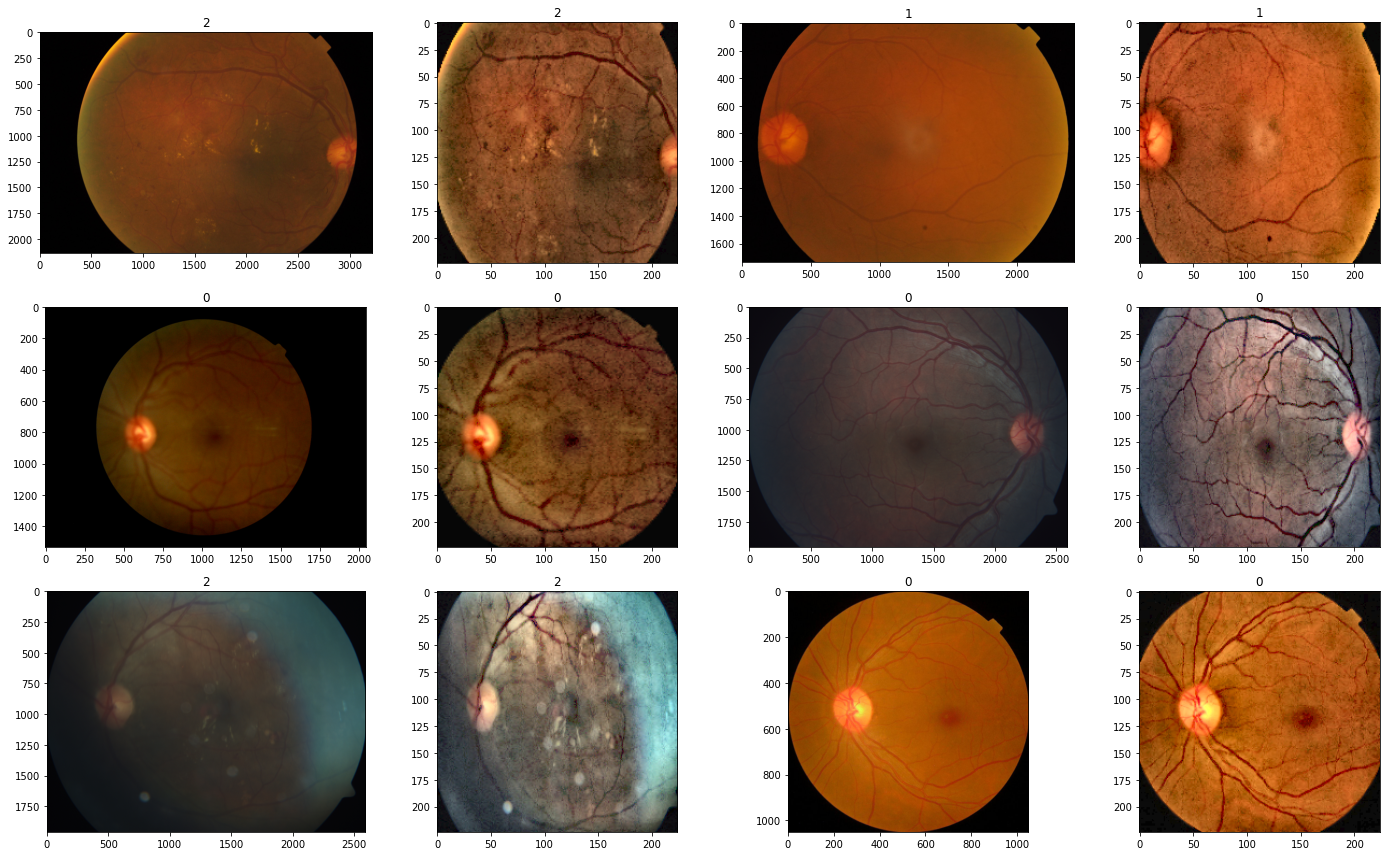

In [6]:
base="../input/aptos2019-blindness-detection/train_images/"
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(0,columns*rows,2):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        image_path=base+image_path
        img=cv2.imread(image_path)
        
        img_processed = new_preprocess_image(img)
        img_processed = cv2.cvtColor(img_processed, cv2.COLOR_BGR2RGB)
        img_processed = cv2.normalize(img_processed, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
        
        fig.add_subplot(rows, columns, i+2)
        plt.title(image_id)
        plt.imshow(img_processed)
    
    plt.tight_layout()

display_samples(train_df)

In [7]:
datagen=ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    zca_whitening = True,
    preprocessing_function=new_preprocess_image)

train_gen=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../input/aptos2019-blindness-detection/train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    target_size=(image_size,image_size),
    subset='training')

test_gen=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../input/aptos2019-blindness-detection/train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical", 
    target_size=(image_size,image_size),
    subset='validation')


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


In [8]:
y_train = train_df['diagnosis']
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
num_classes = y_train.shape[1]

In [9]:

def create_model():
    dense_121 = DenseNet121(weights='../input/densenet121weights/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)
    x = dense_121.get_layer('conv5_block16_2_conv').output
    x = Conv2D(32, (3, 3), input_shape=[96,96,3], activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(32, activation='relu')(x)
    # and a logistic layer -- let's say we have 5 classes
    predictions = Dense(5, activation='softmax')(x)
    model = Model(inputs=dense_121.input, outputs=predictions)
    return model


model=create_model()
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, amsgrad=True), metrics=['accuracy'])

2022-04-21 10:47:42.629351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 10:47:42.740262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 10:47:42.741022: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 10:47:42.742166: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
# warm up model
for layer in model.layers:
    layer.trainable = False

for i in range(-5,0):
    model.layers[i].trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(1e-3))

model.fit_generator(
    train_gen,
    steps_per_epoch=(len(train_gen)),
    epochs=2,
    workers=2, 
    use_multiprocessing=True,
    verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
2022-04-21 10:47:50.717268: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Pas

Epoch 1/2


2022-04-21 10:48:00.883289: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


184/184 [==============================] - 301s 2s/step - loss: 1.1207
Epoch 2/2
184/184 [==============================] - 259s 1s/step - loss: 0.8253


In [11]:
for layer in model.layers:
    layer.trainable = True

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early= EarlyStopping(monitor='val_loss', mode ='min', verbose = 1, patience = 20)

checkpoint = ModelCheckpoint('../working/dr-densenet121.h5',
                            monitor='val_loss',
                            verbose=1, 
                            save_best_only=False,
                            save_weights_only=True,
                             mode='min',)
csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)
callbacks_list=[early,checkpoint,csv_logger]

In [13]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=1e-4, amsgrad=True), 
    metrics=['accuracy'])

history=model.fit_generator(
    train_gen,              
    steps_per_epoch=len(train_gen),
    validation_data=test_gen,                    
    validation_steps=len(test_gen),
    epochs=25,
    callbacks = callbacks_list, 
    use_multiprocessing = True,
    verbose=1)

Epoch 1/25
184/184 [==============================] - 495s 3s/step - loss: 0.7673 - accuracy: 0.7116 - val_loss: 0.7241 - val_accuracy: 0.7350

Epoch 00001: saving model to ../working/dr-densenet121.h5
Epoch 2/25
184/184 [==============================] - 437s 2s/step - loss: 0.6203 - accuracy: 0.7447 - val_loss: 0.6471 - val_accuracy: 0.7336

Epoch 00002: saving model to ../working/dr-densenet121.h5
Epoch 3/25
184/184 [==============================] - 434s 2s/step - loss: 0.5626 - accuracy: 0.7611 - val_loss: 0.6219 - val_accuracy: 0.7514

Epoch 00003: saving model to ../working/dr-densenet121.h5
Epoch 4/25
184/184 [==============================] - 434s 2s/step - loss: 0.5191 - accuracy: 0.7867 - val_loss: 0.7248 - val_accuracy: 0.7473

Epoch 00004: saving model to ../working/dr-densenet121.h5
Epoch 5/25
184/184 [==============================] - 434s 2s/step - loss: 0.4824 - accuracy: 0.8020 - val_loss: 0.5875 - val_accuracy: 0.7650

Epoch 00005: saving model to ../working/dr-dense

In [14]:
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,0.767252,0.711604,0.724105,0.734973
1,0.620259,0.744710,0.647127,0.733607
2,0.562627,0.761092,0.621906,0.751366
3,0.519108,0.786689,0.724755,0.747268
4,0.482396,0.802048,0.587514,0.765027
5,0.459092,0.812969,0.582884,0.771858
6,0.423099,0.822526,0.676562,0.740437
7,0.369878,0.848464,0.649161,0.770492
8,0.354824,0.852560,0.575241,0.784153
9,0.323652,0.867577,0.587558,0.795082


<AxesSubplot:>

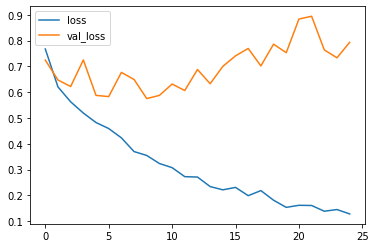

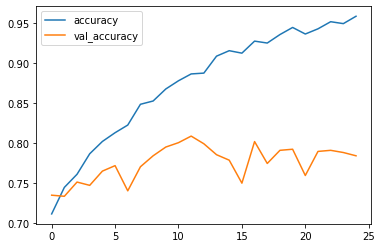

In [15]:
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

In [16]:
def get_data(train_generator):
    x=np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
    y=np.concatenate([train_generator.next()[1] for i in range(train_generator.__len__())])
    print(x.shape)
    print(y.shape)
    return (x,y)

def convert_to(arr):
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            arr[i][j]= 1 if arr[i][j] >= 0.5 else  0
    return arr


def accg(preds,val):
    total=len(val)
    cnt=0
    for i in range(len(preds)):
        if (preds[i]==val[i]).all():
            cnt+=1
    print(cnt)
    return cnt/total

x_val,y_val=get_data(test_gen)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


(732, 224, 224, 3)
(732, 5)


In [17]:
y_preds=model.predict(x_val)
y_preds=convert_to(y_preds)
print('The accuracy is ',accg(y_preds,y_val))

248
The accuracy is  0.33879781420765026
